In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    color = 'r'
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_XCRD
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [7]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_XCRD
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 200

ng =10

ng_refs = (/ 2 , 2 , 6 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 340

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /0.4 , 0.4 , 0.4 , 0.4,
     &     0.4 , 0.4 , 0.4 , 0.4,
     &     0.4 , 0.7/

atmosphere_profiles/mls75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

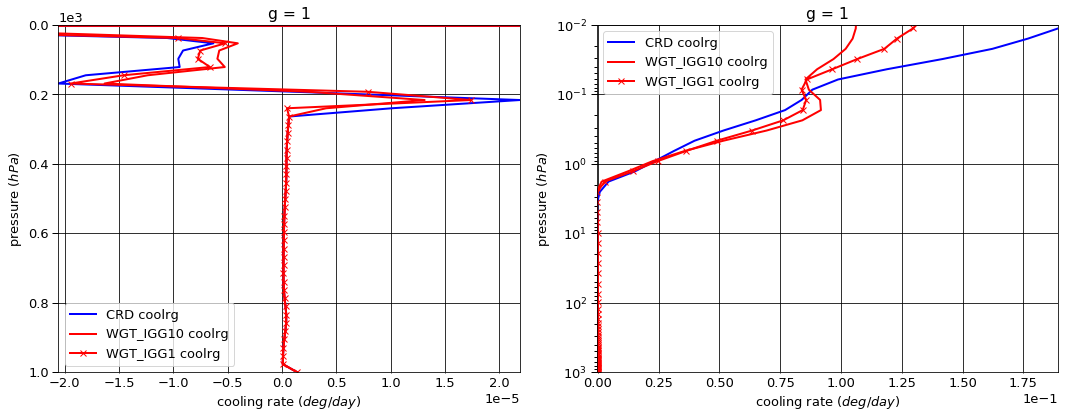

# Figure: cooling rate g-group 2

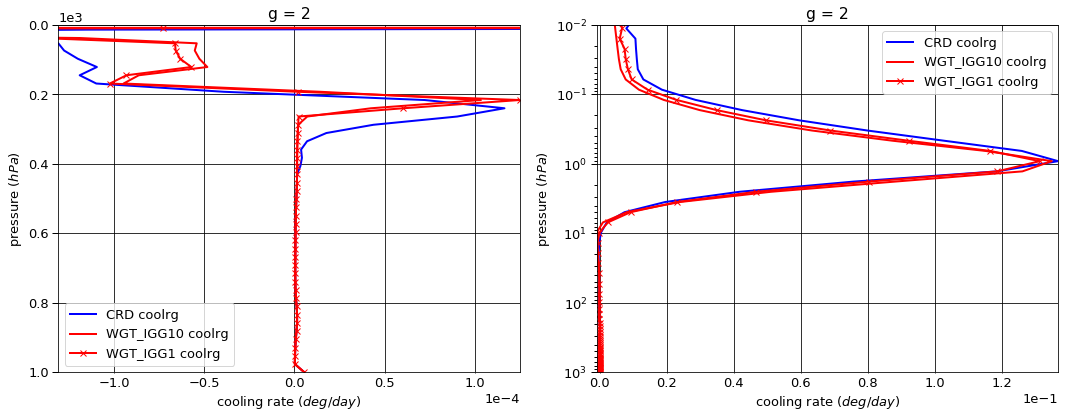

# Figure: cooling rate g-group 3

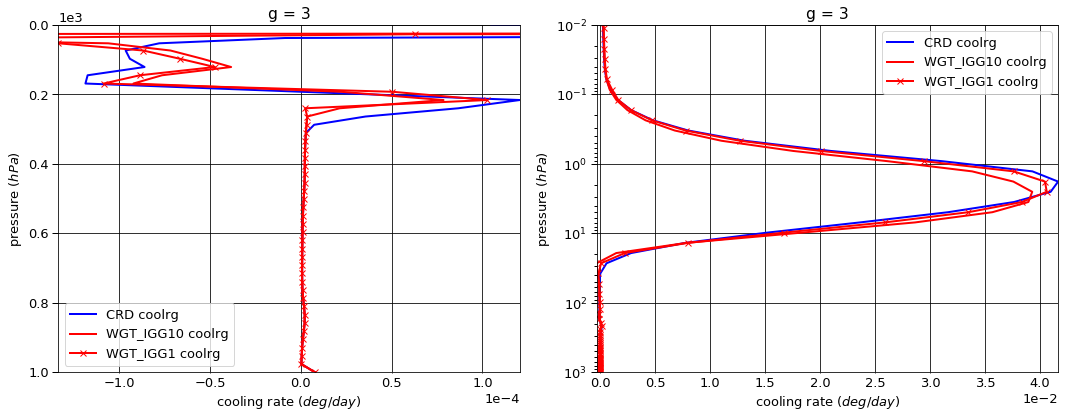

# Figure: cooling rate g-group 4

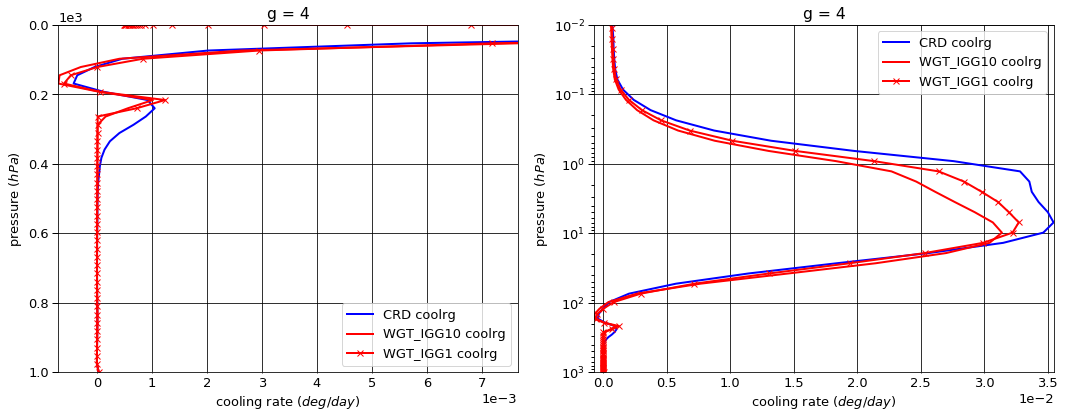

# Figure: cooling rate g-group 5

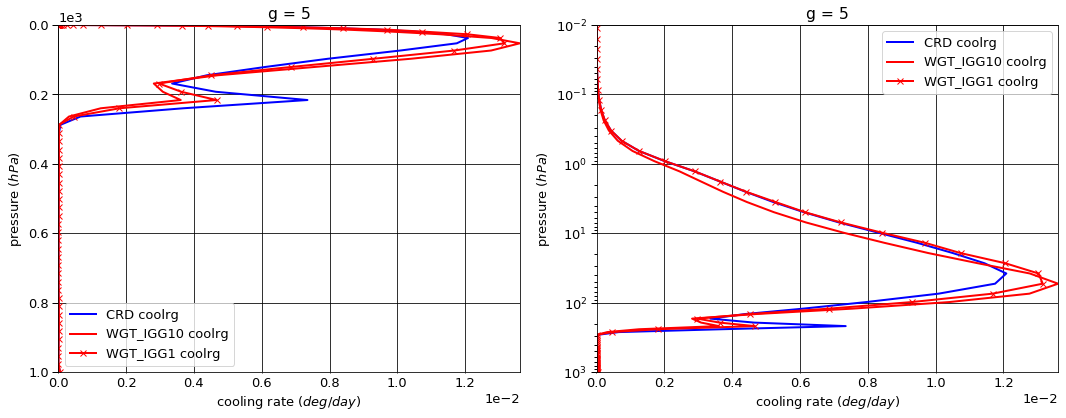

# Figure: cooling rate g-group 6

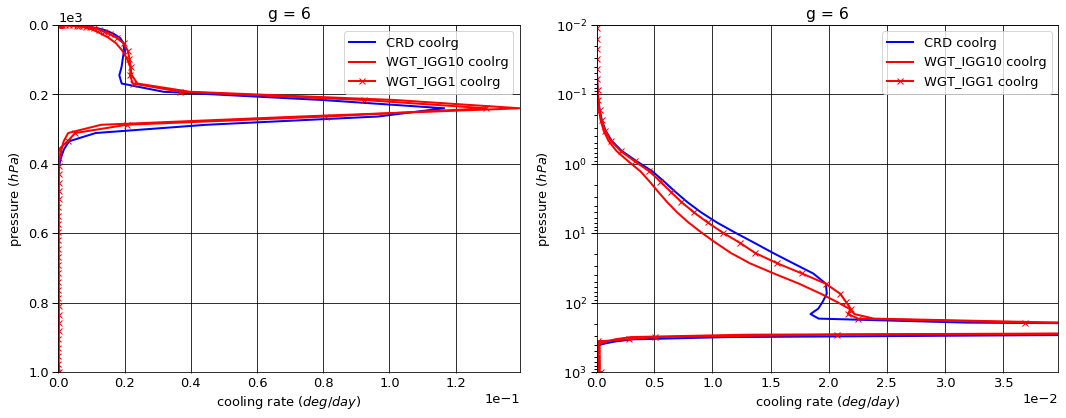

# Figure: cooling rate g-group 7

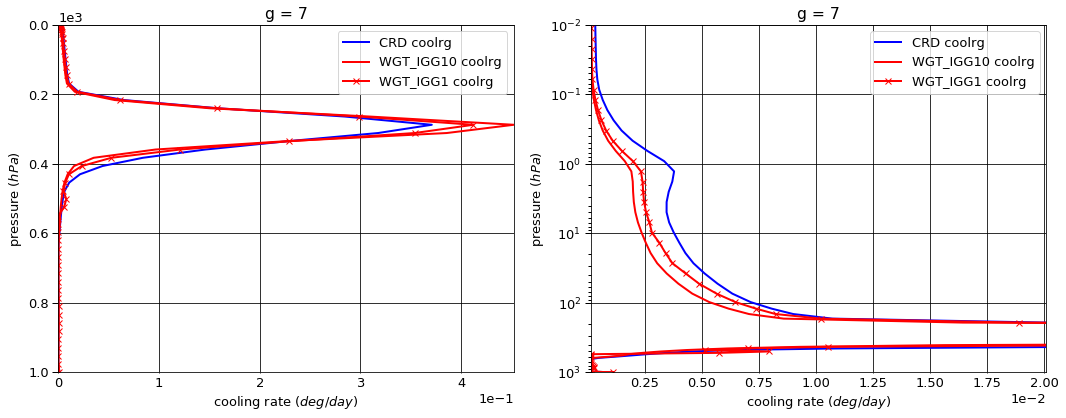

# Figure: cooling rate g-group 8

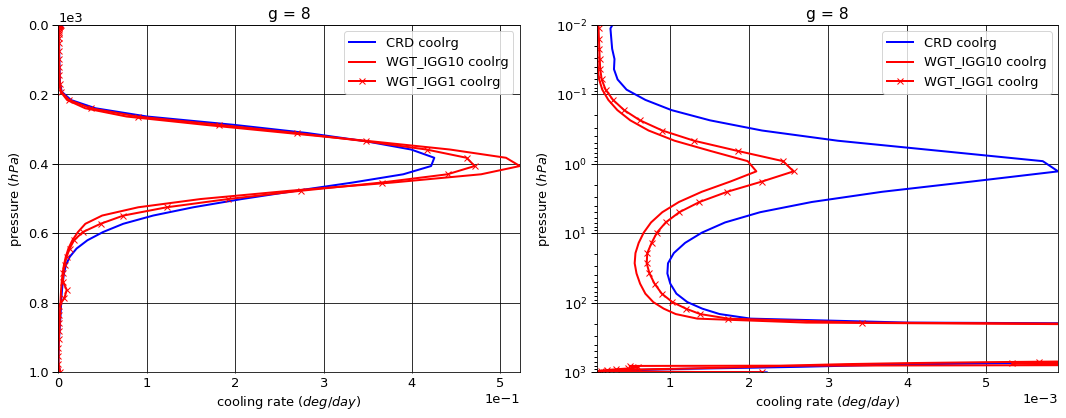

# Figure: cooling rate g-group 9

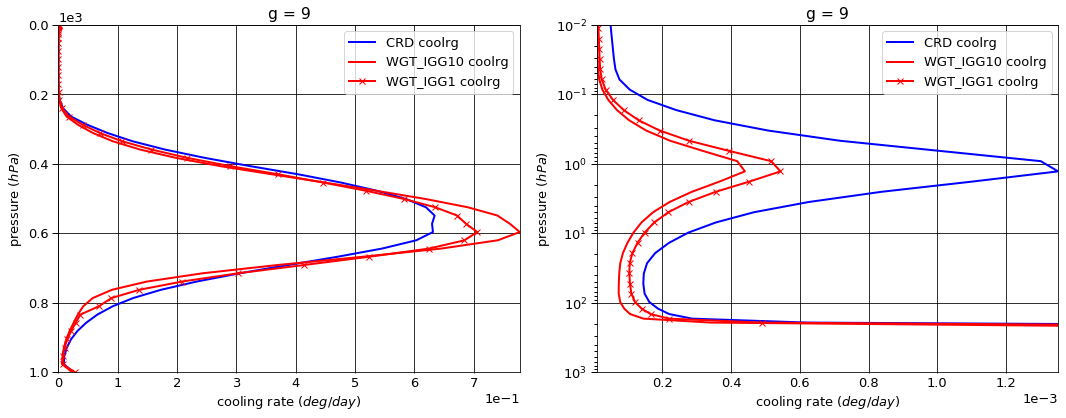

# Figure: cooling rate g-group 10

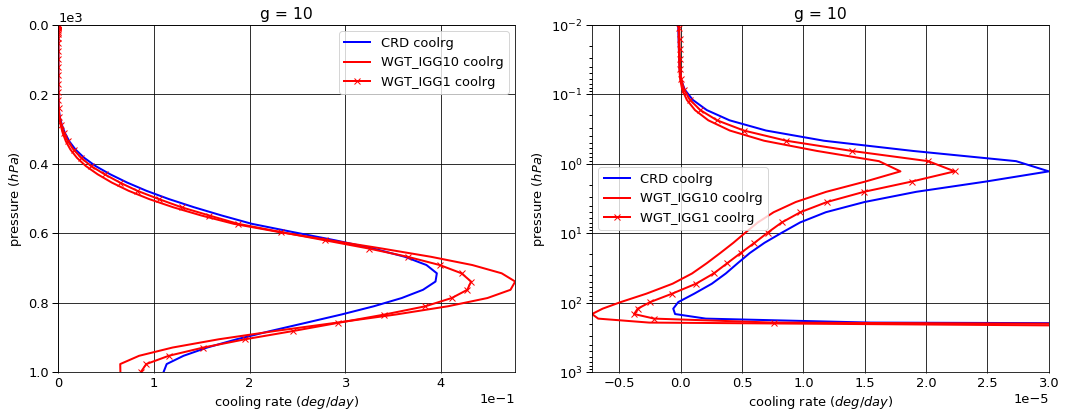

# Figure: cooling rate g-group total

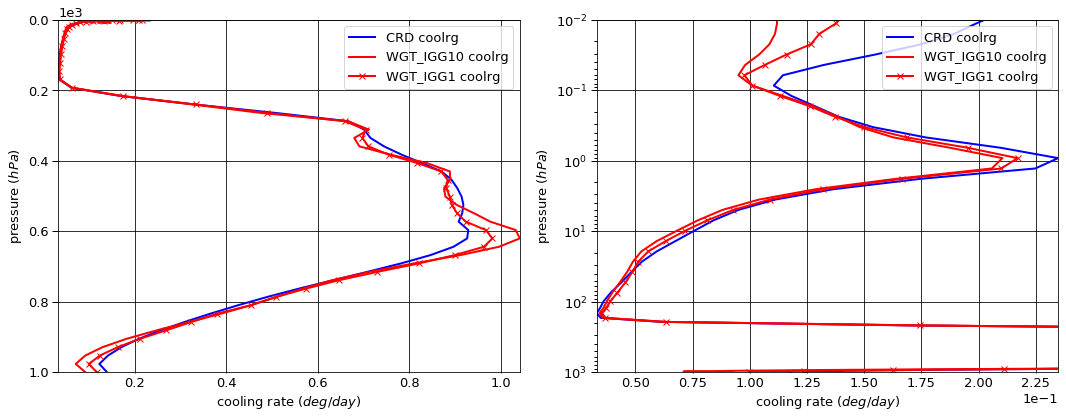

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.006920   0.000000  -0.006920
   1013.0   76     -0.011469   0.011465  -0.000004
2  0.0      1      -0.031230   0.000000  -0.031230
   1013.0   76     -0.042295   0.042279  -0.000015
3  0.0      1      -0.041330   0.000000  -0.041330
   1013.0   76     -0.062875   0.062854  -0.000022
4  0.0      1      -0.148463   0.000000  -0.148463
   1013.0   76     -0.273751   0.273655  -0.000096
5  0.0      1      -0.213567   0.000000  -0.213567
   1013.0   76     -0.428591   0.428449  -0.000142
6  0.0      1      -1.483736   0.000000  -1.483736
   1013.0   76     -2.917730   2.916711  -0.001019
7  0.0      1      -5.150715   0.000000  -5.150715
   1013.0   76     -8.892319   8.889220  -0.003099
8  0.0      1     -11.095159   0.000000 -11.095159
   1013.0   76    -16.773507  16.767430  -0.006076
9  0.0      1     -24.642797   0.000000 -24.642797
   1013.0   76    -32.405981  32.332728  -0.073253
10 0.0      1     -17.500894   0.000000 -17.500894
   1013.0   76    -20.507278  19.632284  -0.874994


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.006935   0.000000  -0.006935
   1013.0   76     -0.011469   0.011465  -0.000004
2  0.0      1      -0.032024   0.000000  -0.032024
   1013.0   76     -0.042295   0.042279  -0.000015
3  0.0      1      -0.041635   0.000000  -0.041635
   1013.0   76     -0.062875   0.062854  -0.000022
4  0.0      1      -0.145043   0.000000  -0.145043
   1013.0   76     -0.273751   0.273655  -0.000096
5  0.0      1      -0.211203   0.000000  -0.211203
   1013.0   76     -0.428591   0.428449  -0.000142
6  0.0      1      -1.456650   0.000000  -1.456650
   1013.0   76     -2.917730   2.916711  -0.001019
7  0.0      1      -5.115095   0.000000  -5.115095
   1013.0   76     -8.892319   8.889220  -0.003099
8  0.0      1     -11.038071   0.000000 -11.038071
   1013.0   76    -16.773507  16.767496  -0.006011
9  0.0      1     -24.667469   0.000000 -24.667469
   1013.0   76    -32.405981  32.344632  -0.061349
10 0.0      1     -17.476591   0.000000 -17.476591
   1013.0   76    -20.507278  20.249884  -0.257394


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.006980   0.000000  -0.006980
   1013.0   76     -0.011469   0.011465  -0.000004
2  0.0      1      -0.031649   0.000000  -0.031649
   1013.0   76     -0.042295   0.042279  -0.000015
3  0.0      1      -0.041581   0.000000  -0.041581
   1013.0   76     -0.062875   0.062854  -0.000022
4  0.0      1      -0.145462   0.000000  -0.145462
   1013.0   76     -0.273751   0.273655  -0.000096
5  0.0      1      -0.212284   0.000000  -0.212284
   1013.0   76     -0.428591   0.428449  -0.000142
6  0.0      1      -1.461574   0.000000  -1.461574
   1013.0   76     -2.917730   2.916711  -0.001019
7  0.0      1      -5.121639   0.000000  -5.121639
   1013.0   76     -8.892319   8.889220  -0.003099
8  0.0      1     -11.056183   0.000000 -11.056183
   1013.0   76    -16.773507  16.767496  -0.006011
9  0.0      1     -24.691319   0.000000 -24.691319
   1013.0   76    -32.405981  32.332376  -0.073605
10 0.0      1     -17.481244   0.000000 -17.481244
   1013.0   76    -20.507278  20.115824  -0.391454


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                      
1  0.0      1     -0.000014  0.000000e+00 -1.439790e-05
   1013.0   76     0.000000 -1.734723e-18  8.470329e-22
2  0.0      1     -0.000794  0.000000e+00 -7.941910e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
3  0.0      1     -0.000304  0.000000e+00 -3.044090e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
4  0.0      1      0.003420  0.000000e+00  3.419560e-03
   1013.0   76     0.000000  0.000000e+00 -1.355253e-20
5  0.0      1      0.002364  0.000000e+00  2.363770e-03
   1013.0   76     0.000000  0.000000e+00 -2.710505e-20
6  0.0      1      0.027087  0.000000e+00  2.708660e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
7  0.0      1      0.035621  0.000000e+00  3.562070e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
8  0.0      1      0.057088  0.000000e+00  5.708800e-02
   1013.0   76     0.000000  6.600000e-05  6.581760e-05
9  0.0      1     -0.024672  0.000000e+00 -2.467200e-02
   1013.0   76     0.000000  1.190400e-02  1.190460e-02
10 0.0      1      0.024303  0.000000e+00  2.430300e-02
   1013.0   76     0.000000  6.176000e-01  6.176005e-01


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                      
1  0.0      1     -0.000060  0.000000e+00 -5.969080e-05
   1013.0   76     0.000000 -1.734723e-18  8.470329e-22
2  0.0      1     -0.000420  0.000000e+00 -4.195930e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
3  0.0      1     -0.000251  0.000000e+00 -2.510080e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
4  0.0      1      0.003001  0.000000e+00  3.001360e-03
   1013.0   76     0.000000  0.000000e+00 -1.355253e-20
5  0.0      1      0.001283  0.000000e+00  1.282650e-03
   1013.0   76     0.000000  0.000000e+00 -2.710505e-20
6  0.0      1      0.022163  0.000000e+00  2.216270e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
7  0.0      1      0.029076  0.000000e+00  2.907620e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
8  0.0      1      0.038976  0.000000e+00  3.897600e-02
   1013.0   76     0.000000  6.600000e-05  6.581760e-05
9  0.0      1     -0.048522  0.000000e+00 -4.852200e-02
   1013.0   76     0.000000 -3.520000e-04 -3.518480e-04
10 0.0      1      0.019650  0.000000e+00  1.965000e-02
   1013.0   76     0.000000  4.835400e-01  4.835407e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      2.059069e-01
   1001.112500 75     1.405021e-06
2  0.000312    1      6.472078e-03
   1001.112500 75     5.525076e-06
3  0.000312    1      1.049311e-04
   1001.112500 75     7.807388e-06
4  0.000312    1      4.946904e-04
   1001.112500 75     3.458588e-05
5  0.000312    1      3.237349e-07
   1001.112500 75     5.144073e-05
6  0.000312    1      2.649008e-05
   1001.112500 75     3.681149e-04
7  0.000312    1      2.738161e-04
   1001.112500 75     1.119481e-03
8  0.000312    1      1.734339e-04
   1001.112500 75     2.226541e-03
9  0.000312    1      2.855519e-05
   1001.112500 75     2.579345e-02
10 0.000312    1     -3.613493e-07
   1001.112500 75     1.099830e-01


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      9.374910e-02
   1001.112500 75     1.405021e-06
2  0.000312    1      2.024684e-03
   1001.112500 75     5.525076e-06
3  0.000312    1      1.667028e-04
   1001.112500 75     7.807388e-06
4  0.000312    1      4.548807e-04
   1001.112500 75     3.458589e-05
5  0.000312    1      2.932357e-07
   1001.112500 75     5.144073e-05
6  0.000312    1      1.975295e-05
   1001.112500 75     3.681149e-04
7  0.000312    1      1.087279e-04
   1001.112500 75     1.119481e-03
8  0.000312    1      5.093399e-05
   1001.112500 75     2.171101e-03
9  0.000312    1      1.887489e-06
   1001.112500 75     2.365779e-02
10 0.000312    1     -2.640352e-07
   1001.112500 75     6.492653e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      1.245888e-01
   1001.112500 75     1.405021e-06
2  0.000312    1      3.462723e-03
   1001.112500 75     5.525076e-06
3  0.000312    1      1.700515e-04
   1001.112500 75     7.807388e-06
4  0.000312    1      4.922902e-04
   1001.112500 75     3.458589e-05
5  0.000312    1      3.380936e-07
   1001.112500 75     5.144073e-05
6  0.000312    1      2.395796e-05
   1001.112500 75     3.681149e-04
7  0.000312    1      1.385444e-04
   1001.112500 75     1.119481e-03
8  0.000312    1      6.950681e-05
   1001.112500 75     2.171101e-03
9  0.000312    1      5.660210e-06
   1001.112500 75     2.746588e-02
10 0.000312    1     -2.385780e-07
   1001.112500 75     8.612688e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.121578e-01
   1001.112500 75     0.000000e+00
2  0.000312    1     -4.447393e-03
   1001.112500 75     8.470329e-22
3  0.000312    1      6.177170e-05
   1001.112500 75     0.000000e+00
4  0.000312    1     -3.980971e-05
   1001.112500 75     6.776264e-21
5  0.000312    1     -3.049920e-08
   1001.112500 75     6.776264e-21
6  0.000312    1     -6.737132e-06
   1001.112500 75    -5.421011e-20
7  0.000312    1     -1.650883e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.224999e-04
   1001.112500 75    -5.544030e-05
9  0.000312    1     -2.666770e-05
   1001.112500 75    -2.135662e-03
10 0.000312    1      9.731406e-08
   1001.112500 75    -4.505648e-02


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -8.131811e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -3.009355e-03
   1001.112500 75     8.470329e-22
3  0.000312    1      6.512039e-05
   1001.112500 75     0.000000e+00
4  0.000312    1     -2.400200e-06
   1001.112500 75     6.776264e-21
5  0.000312    1      1.435875e-08
   1001.112500 75     6.776264e-21
6  0.000312    1     -2.532129e-06
   1001.112500 75    -5.421011e-20
7  0.000312    1     -1.352717e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.039271e-04
   1001.112500 75    -5.544030e-05
9  0.000312    1     -2.289498e-05
   1001.112500 75     1.672427e-03
10 0.000312    1      1.227713e-07
   1001.112500 75    -2.385613e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.314812,0.000000,-60.314812
1013.0,76,-82.315795,81.357074,-0.958721



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.190715,0.000000,-60.190715
1013.0,76,-82.315795,81.986644,-0.329150



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.249915,0.000000,-60.249915
1013.0,76,-82.315795,81.840328,-0.475466



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.124097,0.00000,0.124097
1013.0,76,0.000000,0.62957,0.629571



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.064897,0.000000,0.064897
1013.0,76,0.000000,0.483254,0.483255


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.213481
1001.112500,75,0.139591



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.096577
1001.112500,75,0.092344



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.128952
1001.112500,75,0.117352



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.116904
1001.112500,75,-0.047248



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.084529
1001.112500,75,-0.022239


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000150,0.000145
2,0.000525,0.000521
3,0.000825,0.000792
4,0.003525,0.003422
5,0.005775,0.005468
6,0.037575,0.036493
7,0.114900,0.111318
8,0.211525,0.207564
9,0.390375,0.393311


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.384515e-18
2,5.623149e-19
3,4.227122e-19
4,4.626733e-20
5,1.509806e-19
6,1.832682e-20
7,2.224606e-21
8,2.700344e-22
9,3.277820e-23


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.384515e-18,NaN,0.000150,0.000145,0.000150,0.000145,1.0
2,5.623149e-19,0.104432,0.000525,0.000521,0.000675,0.000666,1.0
3,4.227122e-19,0.751736,0.000825,0.000792,0.001500,0.001458,10.0
4,4.626733e-20,0.109454,0.003525,0.003422,0.005025,0.004880,10.0
5,1.509806e-19,3.263222,0.005775,0.005468,0.010800,0.010347,500.0
6,1.832682e-20,0.121385,0.037575,0.036493,0.048375,0.046840,500.0
7,2.224606e-21,0.121385,0.114900,0.111318,0.163275,0.158159,500.0
8,2.700344e-22,0.121385,0.211525,0.207564,0.374800,0.365723,500.0
9,3.277820e-23,0.121385,0.390375,0.393311,0.765175,0.759034,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     2.421385e-17  1.209787e-17   2.001497  1.442993e-03
      2  0.000312     7.127683e-19  3.506122e-19   2.032925  4.219519e-05
      3  0.000312     7.799087e-21  7.159057e-21   1.089401  6.314758e-07
      4  0.000312     3.842137e-21  2.182148e-21   1.760713  2.423808e-07
      5  0.000312     9.371289e-25  9.367648e-25   1.000389  7.978836e-11
      6  0.000312     1.217377e-23  9.401761e-24   1.294839  8.950916e-10
      7  0.000312     5.239128e-23  5.627141e-24   9.310462  2.072209e-09
      8  0.000312     2.333858e-23  1.182995e-24  19.728386  8.554632e-10
      9  0.000312     3.931208e-24  1.312115e-25  29.960850  1.406189e-10
      10 0.000312     6.819399e-26  1.400918e-26   4.867806  4.423146e-12
2     1  0.000750     2.424147e-17  1.211094e-17   2.001618  5.818661e-04
      2  0.000750     7.170107e-19  3.529848e-19   2.031279  1.710270e-05
      3  0.000750     7.910898e-21  7.260480e-21   1.089583  2.579715e-07
      4  0.000750     3.875514e-21  2.198338e-21   1.762929  9.841894e-08
      5  0.000750     1.297887e-24  1.297510e-24   1.000291  4.451207e-11
      6  0.000750     1.232926e-23  9.526925e-24   1.294149  3.652404e-10
      7  0.000750     5.253052e-23  5.657132e-24   9.285716  8.371858e-10
      8  0.000750     2.349589e-23  1.187433e-24  19.787139  3.468190e-10
      9  0.000750     3.952407e-24  1.318010e-25  29.987676  5.694243e-11
      10 0.000750     6.875267e-26  1.408830e-26   4.880124  1.795813e-12
3     1  0.001052     2.430228e-17  1.213882e-17   2.002030  8.179755e-04
      2  0.001052     7.259932e-19  3.578984e-19   2.028490  2.429924e-05
      3  0.001052     8.104779e-21  7.431793e-21   1.090555  3.704508e-07
      4  0.001052     3.941322e-21  2.227328e-21   1.769530  1.401243e-07
      5  0.001052     1.566079e-24  1.565679e-24   1.000256  7.532360e-11
      6  0.001052     1.255511e-23  9.687606e-24   1.295998  5.211914e-10
      7  0.001052     5.282091e-23  5.709831e-24   9.250872  1.181166e-09
      8  0.001052     2.383293e-23  1.195566e-24  19.934431  4.930939e-10
      9  0.001052     3.997857e-24  1.329201e-25  30.077139  8.076209e-11
      10 0.001052     6.993831e-26  1.423992e-26   4.911428  2.560535e-12
4     1  0.001476     2.436593e-17  1.216818e-17   2.002431  1.150438e-03
      2  0.001476     7.356404e-19  3.632021e-19   2.025430  3.456438e-05
      3  0.001476     8.322024e-21  7.624403e-21   1.091498  5.333657e-07
      4  0.001476     4.013187e-21  2.259293e-21   1.776302  1.998135e-07
      5  0.001476     1.939934e-24  1.939506e-24   1.000221  1.308994e-10
      6  0.001476     1.281525e-23  9.877607e-24   1.297405  7.458909e-10
      7  0.001476     5.313230e-23  5.768055e-24   9.211476  1.667812e-09
      8  0.001476     2.419595e-23  1.204504e-24  20.087893  7.019186e-10
      9  0.001476     4.046619e-24  1.341351e-25  30.168232  1.146660e-10
      10 0.001476     7.122318e-26  1.440344e-26   4.944873  3.656161e-12
5     1  0.002070     2.442864e-17  1.219737e-17   2.002779  1.617622e-03
      2  0.002070     7.454517e-19  3.686356e-19   2.022191  4.915959e-05
      3  0.002070     8.556958e-21  7.833927e-21   1.092295  7.688860e-07
      4  0.002070     4.088029e-21  2.293209e-21   1.782668  2.850156e-07
      5  0.002070     2.461233e-24  2.460772e-24   1.000187  2.329389e-10
      6  0.002070     1.310880e-23  1.009971e-23   1.297938  1.069905e-09
      7  0.002070     5.344889e-23  5.830054e-24   9.167821  2.354759e-09
      8  0.002070     2.456592e-23  1.213936e-24  20.236574  9.990452e-10
      9  0.002070     4.096100e-24  1.353968e-25  30.252566  1.627741e-10
      10 0.002070     7.254243e-26  1.457204e-26   4.978194  5.220282e-12
6     1  0.002904     2.449008e-17  1.222634e-17   2.003058  2.274670e-03
      2  0.002904     7.554330e-19  3.742171e-19   2.018703  6.993277e-05
      3  0.002904     8.815184e

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
